In [186]:
import sys
import os
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy as copy
from qca import QCA
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
import matplotlib.pyplot as plt
import measures as ms
from matrix import ops
import numpy as np
from scipy.optimize import curve_fit
from figures import colors, names, lettering, exp_fit, powerlaw_fit, page_fit

%matplotlib inline

from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "axes.labelsize": 9,
    'axes.titlesize': 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)


der = r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data/"

In [189]:
from importlib import reload
import figures
reload(figures)
from figures import lettering

In [4]:
params = dict(
              L=17,
              T=1000.0,
              dt=0.1,
              R=4,
              r=2,
              V="X",
              BC="1-0000",
              IC="c3_f0-2",
              E=0.0,
              N=1,
              totalistic=True,
              hamiltonian=True,
              trotter=True,
              symmetric=True)
Q = QCA(params, der=der)

In [5]:
errs = [0.4, 0.54, 0.728, 0.983, 1.33, 1.79, 2.41, 3.26, 4.39, 5.93, 8.0]
L = 17  # true system size
dt = 0.1

DATA_DER = os.path.join(der,"qeb_decay")
    

def make_data_fname(L, err):
    fname = f"{L+4}-site_rho_{err}-err.npy"
    return os.path.join(DATA_DER, fname)

def make_grid(L, err):
    fname = make_data_fname(L, err)
    rhojs = np.load(fname)
    grid = np.array([ms.get_expectation(rhoj, ops["Z"]) for rhoj in rhojs])
    # clip boundary sites
    grid = grid[:, 2:-2]
    grid = (1 - grid) / 2.0
    return grid

# fitting function
def lifetime_func(x, A, tau, B):
    return A*np.exp(-x / tau) + B

def lifetime_data(err, grid):
    Dgrid = np.array([Q.rolling(np.std, grid[:, j], winsize=int(L/dt)) for j in range(L)]).T
    ys = Dgrid[:, int(L/2)+1]
    ts = dt * np.arange(len(ys))
    # popt = [A, tau, B] = [scale, lifetime, offset]
    tau0 = 2.55 * err**(-1.25)
    popt, pcov = curve_fit(lifetime_func, ts, ys,
                           p0=[0.5, tau0, 0.5],
                           bounds=((0, 0, 0), (np.inf, np.inf, np.inf)))
    perr = np.sqrt(np.diag(pcov))
    return ts, ys, popt, perr 



In [6]:
grids = [make_grid(L, err) for err in errs]

In [222]:
def qeb_lifetime_grids(axs=None, show=True, plot_errs=[3.26, 4.39, 5.93]):
    if axs is None:
        fig, axs = plt.subplots(1, len(plot_errs), sharey=True)
    else:
        fig = plt.gcf()
    col = 0
    for erri, (err, grid) in enumerate(zip(errs, grids)):
        if err in plot_errs:
            ts, ys, popt, perr = lifetime_data(err, grid)
            A, tau, B = popt
            ax = axs[col]
            im = ax.imshow(grid[::int(1/dt)][:L*4+1],
            origin="lower",
            interpolation="none",
            cmap="inferno",
            vmin=0,
            vmax=1)
            ax.axhline(tau, c=f"C{col}", lw=4)
            ax.axhline(tau, c="k", lw=2)
            if col == len(plot_errs)-1:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="15%", pad=0.075)
                fig.colorbar(im, cax=cax, ticks=[0, 1])
                cax.text(2, 0.5, r"$\big \langle \hat P^{(1)}_j  \big \rangle$",
                         transform=cax.transAxes)
            if col == 0:
                ax.set_ylabel(names["time"])
                ax.set_xlabel(names["site"])
            col += 1

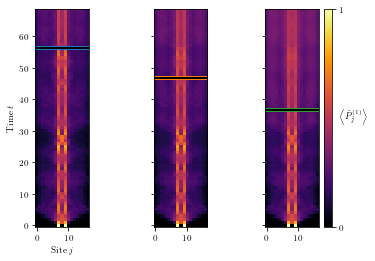

In [223]:
qeb_lifetime_grids()

In [213]:
def qeb_lifetime_lines(ax=None,
                       plot_errs=[4.39, 5.93, 8.0], 
                       shift=0.03, 
                       t0=300):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    P = Q.get_measure("exp_1")
    DP = np.array([Q.rolling(np.std, P[:, j]) for j in range(Q.L)]).T
    ps = DP[:, int(L/2)+1]
    ax.plot(Q.ts[:1-int(Q.L/Q.dt)][:int(t0/dt)], ps[:int(t0/dt)],
            c=colors[4], label=r"$\varepsilon=0.00\%$", lw=1, zorder=100)
    col = 0
    for erri, (err, grid) in enumerate(zip(errs[::], grids[::])):
        if err in plot_errs:
            ts, ys, popt, perr = lifetime_data(err, grid)
            ax.plot(ts[:int(t0/dt)], ys[:int(t0/dt)]-col*shift,
                 label=(r"$\varepsilon=%03.2f$" % round(err, 2))+r"$\%$",
                   lw=1)
            ax.plot(ts[:int(t0/dt)], lifetime_func(ts[:int(t0/dt)], *popt)-col*shift, 
                    c="k", lw=1)
            handles, labels = ax.get_legend_handles_labels()
            #ax.legend(handles[::], labels[::], loc="center", frameon=False,
            #        handlelength=0.5, handletextpad=0.5,
            #       bbox_to_anchor=(0.5, 0.9), ncol=4)
            ax.set_xlabel(names["time"])
            ax.set_ylabel(r"$\Delta \big \langle \hat P^{(1)}_{L/2 \pm 1}  \big \rangle$")
            if col >= 0:
                ax.axhline(-col*shift, c=f"C{col}", ls="--", lw=1)
            col += 1
    return handles, labels

([<matplotlib.lines.Line2D at 0x7f862d3476a0>,
 ['$\\varepsilon=0.00\\%$',
  '$\\varepsilon=4.39$$\\%$',
  '$\\varepsilon=5.93$$\\%$',
  '$\\varepsilon=8.00$$\\%$'])

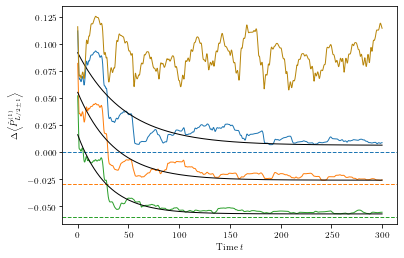

In [214]:
qeb_lifetime_lines()

In [194]:
def qeb_lifetime(ax=None,  plot_errs=[4.39, 5.93, 8.0]):
    if ax is None:
        fig, ax = plt.subplots(1,1) 
    taus = np.zeros_like(errs)
    dtaus = np.zeros_like(errs)
    for erri, (err, grid) in enumerate(zip(errs, grids)):
        ts, ys, popt, perr = lifetime_data(err, grid)
        A, tau, B = popt
        dA, dtau, dB = perr
        taus[erri] = tau
        dtaus[erri] = dtau

    x = errs[2:]
    xs = np.linspace(x[0]*(1-1/10), x[-1]*(1+2/10), 100)
    y = taus[2:]
    dy = dtaus[2:]
    func, m, b = powerlaw_fit(x, y)
    ax.errorbar(x, y, yerr=dy, 
                marker="o",
                ms=2,
                mec="k", 
                ecolor="k",
                mfc="k",
                ls="none")
    for erri, err in enumerate(plot_errs):
        ax.scatter([err], [y[x.index(err)]], color=f"C{erri}", zorder=100, s=10)
    ax.plot(xs, func(xs), color="k", lw=1, zorder=0)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"Admixture $\varepsilon~(\%)$")
    ax.set_ylabel(r"Lifetime $\tau$")
    ax.text(0.51,0.61, f"slope: \n{round(m,1)}", fontsize=9, transform=ax.transAxes)

    ax.minorticks_off()
    print(m)

-0.7028265709677903


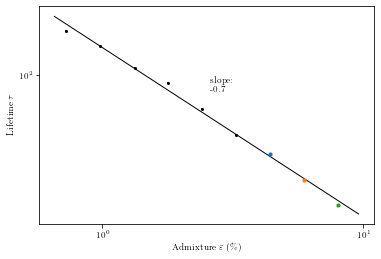

In [195]:
qeb_lifetime()

In [219]:
def qeb_linecuts(ax=None, js = None, t0=300):
    if ax == None:
        fig, ax = plt.subplots(1,1)
    if js == None:
        js = [int(Q.L/2), int(Q.L/2)+1, 0]
    P = Q.get_measure("exp_1")
    DP = np.array([Q.rolling(np.std, P[:, j]) for j in range(Q.L)]).T
    for (j, l, c) in zip(js, (r"L/2$", r"L/2 \pm 1$", r"0,~L-1$"), ("C4", colors[4], "C3")):
        ax.plot(Q.ts[:int(t0/dt)], P[:int(t0/dt), j], label="$j=%s" % l, c=c, lw=1)
    ax.legend(loc="center",frameon=False,
                handlelength=0.5, handletextpad=0.25,
                bbox_to_anchor=(0.5, 0.88), ncol=3)
    ax.set_xlabel(names["time"])
    ax.set_ylabel(r"$\big \langle \hat P^{(1)}_j  \big \rangle$")

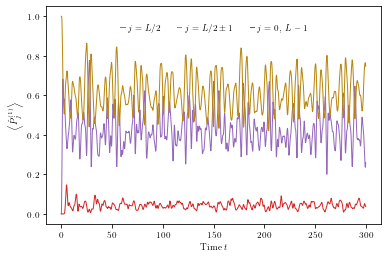

In [197]:
qeb_linecuts()

In [198]:
def qeb_profile(ax=None, t0=500, js=None):
    if ax == None:
        fig, ax = plt.subplots(1,1)
    if js == None:
        js = [0, int(Q.L/2)-1, int(Q.L/2), int(Q.L/2)+1, Q.L-1]
        
    P = Q.get_measure("exp_1")
    Pbar = np.mean(P[int(t0/Q.dt):], axis=0)
    DP = np.array([Q.rolling(np.std, P[:, j]) for j in range(Q.L)]).T
    DPbar = np.mean(DP[int(t0/Q.dt):], axis=0)
    ax.plot(DPbar, marker="o", c="k", ms=2, lw=1)
    for j, c in zip(js,("C3", colors[4], "C4", colors[4], "C3")):
        ax.scatter([j], [DPbar[j]], color=c, zorder=100, s=10)
    ax.set_xlabel(names["site"])
    ax.set_ylabel(r"$\overline{\Delta \big \langle \hat P^{(1)}_j  \big \rangle}$")

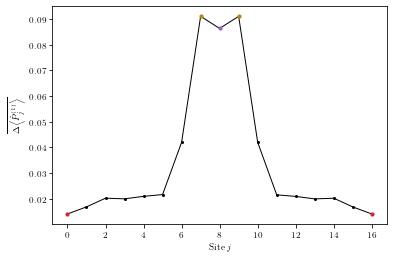

In [199]:
qeb_profile()

-0.7028265709677903


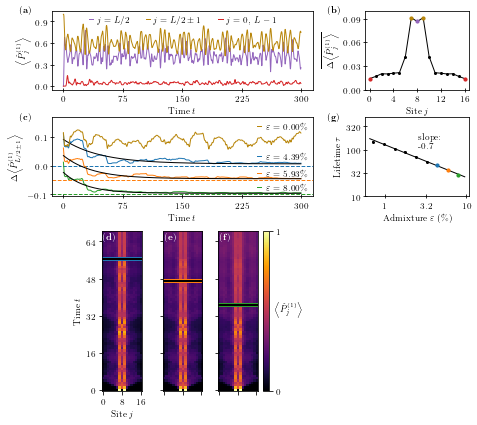

In [249]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(2*3.375, 6))
gs1 = GridSpec(2, 3)
gs1.update(left=0.1, right=0.96, bottom=0.52, top=0.95, wspace=0.5, hspace=0.35)

timeseries_axs = [fig.add_subplot(gs1[0, 0:2]), fig.add_subplot(gs1[1, 0:2])]
sq_axs = [fig.add_subplot(gs1[0,2]), fig.add_subplot(gs1[1,2])]

gs2=GridSpec(1,3)
gs2.update(left=0.12, right=0.62, bottom=0.07, top=0.44, wspace=-0.5, hspace=0.3)

board_axs = [fig.add_subplot(gs2[i]) for i in range(3)]

timeticks = [0, 75, 150, 225, 300]
boardtimeticks = [(L-1)*i for i in range(5)]
siteticks = [0,4,8,12,16]
admixticks = [1, 3.2, 10]

linecutticks = [0.0, 0.3, 0.6, 0.9]
lifelineticks = [-0.1,  0.0, 0.1]
lifetimeticks = [10, 32, 100, 320]
profileticks = [0.0, 0.03, 0.06, 0.09]



qeb_profile(ax=sq_axs[0])
qeb_linecuts(ax=timeseries_axs[0])
handles, labels = qeb_lifetime_lines(ax=timeseries_axs[1], shift=0.05)
qeb_lifetime(ax=sq_axs[1])
qeb_lifetime_grids(axs=board_axs)

timeseries_axs[0].set_xticks(timeticks)
#timeseries_axs[0].set_xticklabels([])
#timeseries_axs[0].set_xlabel("")
timeseries_axs[0].set_yticks(linecutticks)
timeseries_axs[0].tick_params(axis="both", direction="inout")

timeseries_axs[1].set_xticks(timeticks)
timeseries_axs[1].set_xticklabels(timeticks)
timeseries_axs[1].set_yticks(lifelineticks)
timeseries_axs[1].set_ylim(top=0.17)
timeseries_axs[1].tick_params(axis="both", direction="inout")
l0 = timeseries_axs[1].legend([handles[0]], [labels[0]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.88), ncol=1)
l1 = timeseries_axs[1].legend([handles[1]], [labels[1]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.5), ncol=1)
l2 = timeseries_axs[1].legend([handles[2]], [labels[2]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.29), ncol=1)
l3 = timeseries_axs[1].legend([handles[3]], [labels[3]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.11), ncol=1)

for l in [l0, l1, l2]:
    timeseries_axs[1].add_artist(l)
    

sq_axs[0].set_xticks(siteticks)
sq_axs[0].set_yticks(profileticks)
sq_axs[0].tick_params(axis="both", direction="inout")
sq_axs[0].set_ylim(0, 0.1)

sq_axs[1].set_xticks(admixticks)
sq_axs[1].set_yticks(lifetimeticks)
sq_axs[1].set_xticklabels(admixticks)
sq_axs[1].set_yticklabels(lifetimeticks)
sq_axs[1].set_ylim((10, 500))
sq_axs[1].tick_params(axis="both", direction="inout")

for ax in board_axs:
    ax.set_xticks(siteticks[::2])
    ax.set_yticks(boardtimeticks)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
board_axs[0].set_xticklabels(siteticks[::2])
board_axs[0].set_yticklabels(boardtimeticks)

lettering(timeseries_axs[0], -0.1, 1.0, 0) 
lettering(timeseries_axs[1], -0.1, 1.0, 2)
lettering(sq_axs[0], -0.3, 1.0, 1)
lettering(sq_axs[1], -0.3, 1.0, 6)
lettering(board_axs[0], 0.17, 0.96, 3, color="w")
lettering(board_axs[1], 0.17, 0.96, 4, color="w")
lettering(board_axs[2], 0.17, 0.96, 5, color="w")

plt.savefig("figures/figure5_V1.pdf")

-0.7028265709677903


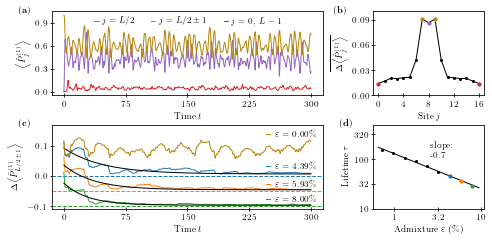

In [250]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(2*3.375, 3.3))
gs1 = GridSpec(2, 3)
gs1.update(left=0.1, right=0.99, bottom=0.12, top=0.95, wspace=0.45, hspace=0.35)

timeseries_axs = [fig.add_subplot(gs1[0, 0:2]), fig.add_subplot(gs1[1, 0:2])]
sq_axs = [fig.add_subplot(gs1[0,2]), fig.add_subplot(gs1[1,2])]



timeticks = [0, 75, 150, 225, 300]
siteticks = [0,4,8,12,16]
admixticks = [1, 3.2, 10]

linecutticks = [0.0, 0.3, 0.6, 0.9]
lifelineticks = [-0.1,  0.0, 0.1]
lifetimeticks = [10, 32, 100, 320]
profileticks = [0.0, 0.03, 0.06, 0.09]



qeb_profile(ax=sq_axs[0])
qeb_linecuts(ax=timeseries_axs[0])
handles, labels = qeb_lifetime_lines(ax=timeseries_axs[1], shift=0.05)
qeb_lifetime(ax=sq_axs[1])
qeb_lifetime_grids(axs=board_axs)

timeseries_axs[0].set_xticks(timeticks)
#timeseries_axs[0].set_xticklabels([])
#timeseries_axs[0].set_xlabel("")
timeseries_axs[0].set_yticks(linecutticks)
timeseries_axs[0].tick_params(axis="both", direction="inout")

timeseries_axs[1].set_xticks(timeticks)
timeseries_axs[1].set_xticklabels(timeticks)
timeseries_axs[1].set_yticks(lifelineticks)
timeseries_axs[1].set_ylim(top=0.17)
timeseries_axs[1].tick_params(axis="both", direction="inout")
l0 = timeseries_axs[1].legend([handles[0]], [labels[0]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.88), ncol=1)
l1 = timeseries_axs[1].legend([handles[1]], [labels[1]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.5), ncol=1)
l2 = timeseries_axs[1].legend([handles[2]], [labels[2]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.29), ncol=1)
l3 = timeseries_axs[1].legend([handles[3]], [labels[3]], loc="center", frameon=False,
                    handlelength=0.5, handletextpad=0.5,
                   bbox_to_anchor=(0.88, 0.11), ncol=1)

for l in [l0, l1, l2]:
    timeseries_axs[1].add_artist(l)
    

sq_axs[0].set_xticks(siteticks)
sq_axs[0].set_yticks(profileticks)
sq_axs[0].tick_params(axis="both", direction="inout")
sq_axs[0].set_ylim(0, 0.1)

sq_axs[1].set_xticks(admixticks)
sq_axs[1].set_yticks(lifetimeticks)
sq_axs[1].set_xticklabels(admixticks)
sq_axs[1].set_yticklabels(lifetimeticks)
sq_axs[1].set_ylim((10, 500))
sq_axs[1].tick_params(axis="both", direction="inout")


lettering(timeseries_axs[0], -0.1, 1.0, 0) 
lettering(timeseries_axs[1], -0.1, 1.0, 2)
lettering(sq_axs[0], -0.3, 1.0, 1)
lettering(sq_axs[1], -0.25, 1.0, 3)

plt.savefig("figures/figure5_V2.pdf")